In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing 
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

daily_train = pd.read_csv('../Datasets\Daily-train.csv')
daily_test = pd.read_csv('../Datasets\Daily-test.csv')

__Selecting the Time Series Data for Our Predictions__

In [2]:
train = daily_train.transpose()
test = daily_test.transpose()

train = train[0]
train = train.iloc[1:]
train = train.dropna()

test = test[0]
test = test.iloc[1:]

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

new_index = pd.RangeIndex(start=len(train), stop=len(train) + len(test))
test.index = new_index

train = pd.DataFrame(train)
train = train[0]
train = train.drop(columns=[0])
train = train.apply(pd.to_numeric)

test = pd.DataFrame(test)
test = test[0]
test = test.drop(columns=[0])
test = test.apply(pd.to_numeric)

series = pd.concat([train, test], axis=1, keys=['Train', 'Test'])

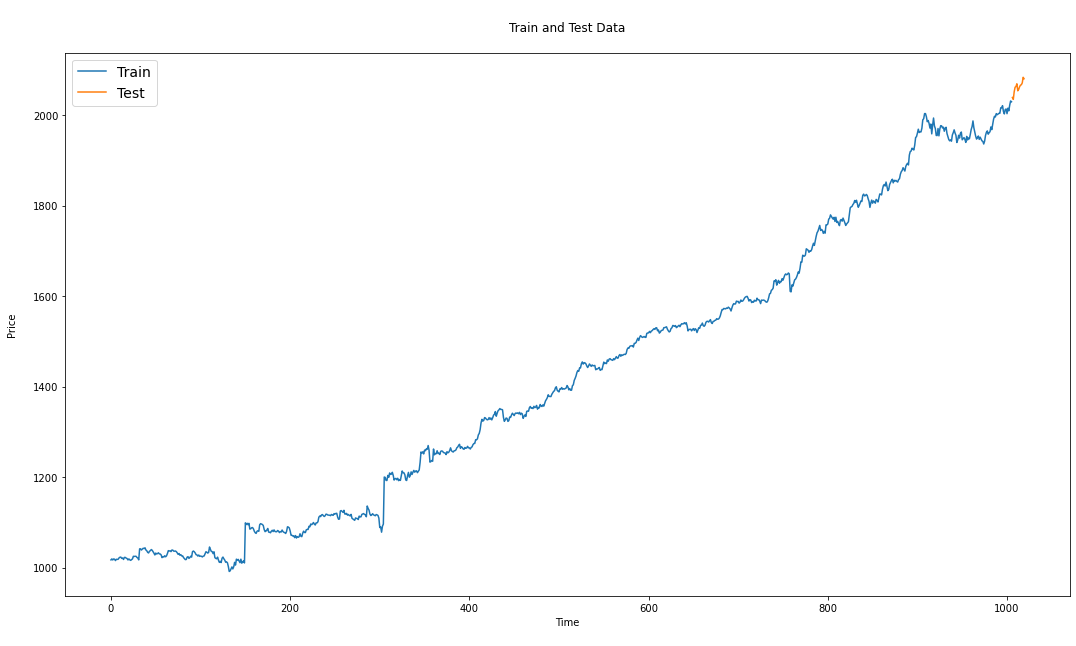

In [3]:
series.plot(figsize=(18,10))
plt.title('\nTrain and Test Data\n')
plt.xlabel('Time\n')
plt.ylabel('Price\n')
plt.legend(fontsize=14)
plt.show()

**Simple Exponential Smoothing using the library SimpleExpSmoothing**

In [4]:
def SES(data, train, test, smoothing_level, number_of_predicted_data):
    # Plot the last 200 elements of our data
    data.tail(200).plot(legend=True, figsize=(18, 10))
    
    # Model 1: Simple Exponential Smoothing with a specified smoothing level
    model1 = SimpleExpSmoothing(train).fit(smoothing_level=smoothing_level, optimized=False)
    Forecast1 = model1.forecast(number_of_predicted_data)
    
    # Plot the forecast from Model 1
    Forecast1.plot(color='green', legend=True, label='Forecast1')
    
    # Calculate metrics for Model 1
    mae = mean_absolute_error(test, Forecast1)
    mape = mean_absolute_percentage_error(test, Forecast1)
    mse = mean_squared_error(test, Forecast1)
    rmse = np.sqrt(mean_absolute_error(test, Forecast1))
    print(f'Metrics to evaluate the Forecasting with a={smoothing_level}')
    print(f'MAE - manual: {mae}')
    print(f'MAPE - manual: {mape}')
    print(f'MSE - manual: {mse}')
    print(f'RMSE - manual: {rmse}\n')
    
    # Model 2: Simple Exponential Smoothing with optimized smoothing level
    model2 = SimpleExpSmoothing(train).fit()
    Forecast2 = model2.forecast(number_of_predicted_data)
    optimized_smoothing_level = model2.params['smoothing_level']
    
    # Plot the forecast from Model 2
    Forecast2.plot(color='red', legend=True, label='Forecast2')
    
    # Calculate metrics for Model 2
    mae = mean_absolute_error(test, Forecast2)
    mape = mean_absolute_percentage_error(test, Forecast2)
    mse = mean_squared_error(test, Forecast2)
    rmse = np.sqrt(mean_absolute_error(test, Forecast2))
    print(f"Metrics to evaluate the Forecasting with a={optimized_smoothing_level}")
    print(f'MAE - manual: {mae}')
    print(f'MAPE - manual: {mape}')
    print(f"MSE - manual: {mse}")
    print(f'RMSE - manual: {rmse}')

    return optimized_smoothing_level

Metrics to evaluate the Forecasting with a=0.2
MAE - manual: 43.111657085739566
MAPE - manual: 0.020869892927582713
MSE - manual: 2034.1941603518678
RMSE - manual: 6.565946777559164

Metrics to evaluate the Forecasting with a=0.9903366949267434
MAE - manual: 32.01110939261524
MAPE - manual: 0.01548557241877052
MSE - manual: 1200.2903082194493
RMSE - manual: 5.6578361051390695


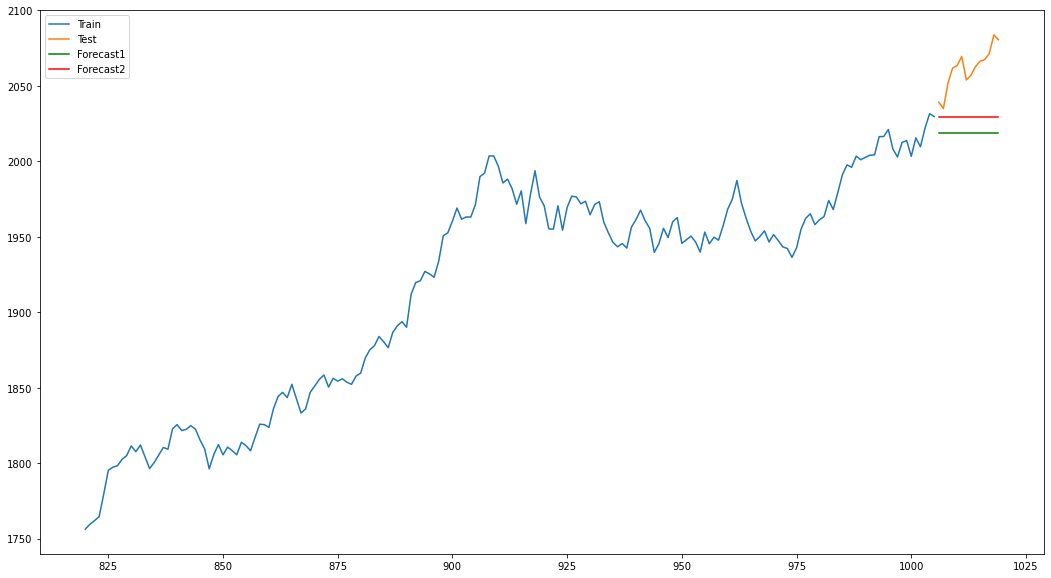

In [5]:
optimized_smoothing_level = SES(series, train, test, 0.2, len(test) )

**Simple Exponential Smoothing (SES) Implementation**<br><br>
**Mathematical Model**

![](SeS.jpg)

## Mathematical Model Explanation

In this model, we employ a technique known as Simple Exponential Smoothing to make predictions. Let's delve into the key components:

#### Prediction Function
We calculate the predicted value at time (t+1) using the formula:

𝑭𝒕+𝟏 = 𝑭𝒕 + α * ( 𝒚𝒕 - 𝑭𝒕 )

- **𝑭𝒕+𝟏**: Represents the predicted value at time (t+1).
- **𝑭𝒕**: Denotes the previous predicted value at time t.
- **α**: The smoothing factor, typically set to values like 0.1 or 0.2. The α factor plays a crucial role in balancing past and present observations.
- **( 𝒚𝒕 - 𝑭𝒕 )**: This term signifies the difference between the previous observed (actual) value at time t and the prior prediction. This difference is the cornerstone of the method.

#### Simple Exponential Smoothing
The Simple Exponential Smoothing method applies the above mathematical model repeatedly for each consecutive period to generate forecasts for the entire time series.

In [6]:
""""

SES: Simple Exponential Smoothing
F[t+1] = F[t] + a*Error[t], where 'a' is the smoothing parameter (the usual values of a is 0.1 and 0.2)
Error[t] = y[t] - F[t]: Deviation between the previous observed value and the previous forecasted value
a * (y[t] - F[t]): Weighted deviation based on the smoothing parameter
previous_forecast + alpha * (previous_observation - previous_forecast): Calculation of the current forecast

Calculate the current forecast using SES method
F[t+1] = F[t] + a * (y[t] - F[t])
F[t+1]: Current forecasted value at time t+1
F[t]: Previous forecasted value at time t
y[t]: Previous observed (actual) value at time t
a : Smoothing parameter

"""

def SES_manual(train , test, alpha, number_of_predicted_data):
    # Initialize forecast and error lists with zeros and the first forecast and error values
    forecast = [0] * (len(train) + number_of_predicted_data)
    error = [0] * (len(train) + number_of_predicted_data)
    forecast[1] = train.iloc[0]
    error[1] = train.iloc[1] - forecast[1]

    # Perform Simple Exponential Smoothing
    for i in range(1, len(train) + number_of_predicted_data):
        if i < len(train):
            # Calculate forecast and error when index is within the training data range
            forecast[i] = forecast[i-1] + alpha * error[i-1]
            error[i] = train.iloc[i] - forecast[i]
        else:
            # Calculate forecast and error when index is beyond the training data range
            forecast[i] = forecast[i-1] + alpha * error[i-1]
            error[i] = forecast[i] - forecast[i]

    # Convert forecast and error lists to DataFrames
    forecast = pd.DataFrame(forecast)
    forecast = forecast.rename(columns={0: "forecasting"})
    error = pd.DataFrame(error)
    error = error.rename(columns={0: 'error'})

    # Calculate evaluation metrics
    mae = mean_absolute_error(test, forecast.tail(len(test)))
    mape = mean_absolute_percentage_error(test, forecast.tail(len(test)))
    mse = mean_squared_error(test, forecast.tail(len(test)))
    rmse = np.sqrt(mean_absolute_error(test, forecast.tail(len(test))))
    print(f'Metrics to evaluate the Forecasting with a={alpha}')
    print(f'MAE - manual: {mae}')
    print(f'MAPE - manual: {mape}')
    print(f'MSE - manual: {mse}')
    print(f'RMSE - manual: {rmse}\n')

    # Plot the last 200 values of the train, test, and forecast data
    fig, ax = plt.subplots(figsize=(18, 10))
    train.tail(200).dropna().plot(ax=ax, label='Train', color='blue',  legend=True)
    forecast.tail(200).dropna().plot(ax=ax, label='Forecast', color='green', legend=True)
    test.dropna().plot(ax=ax, label='Test', color='red', legend=True)
    ax.set_title('The last 200 values of Train, Test Data and Forecasting')
    ax.set_xlabel('Index')
    ax.set_ylabel('Price')
    plt.show()

    return forecast, error

__Visualizing and Evaluating the SES Method with α=0.2 Using Multiple Performance Metrics__

Metrics to evaluate the Forecasting with a=0.2
MAE - manual: 43.11165708574025
MAPE - manual: 0.020869892927583043
MSE - manual: 2034.1941603519267
RMSE - manual: 6.5659467775592155



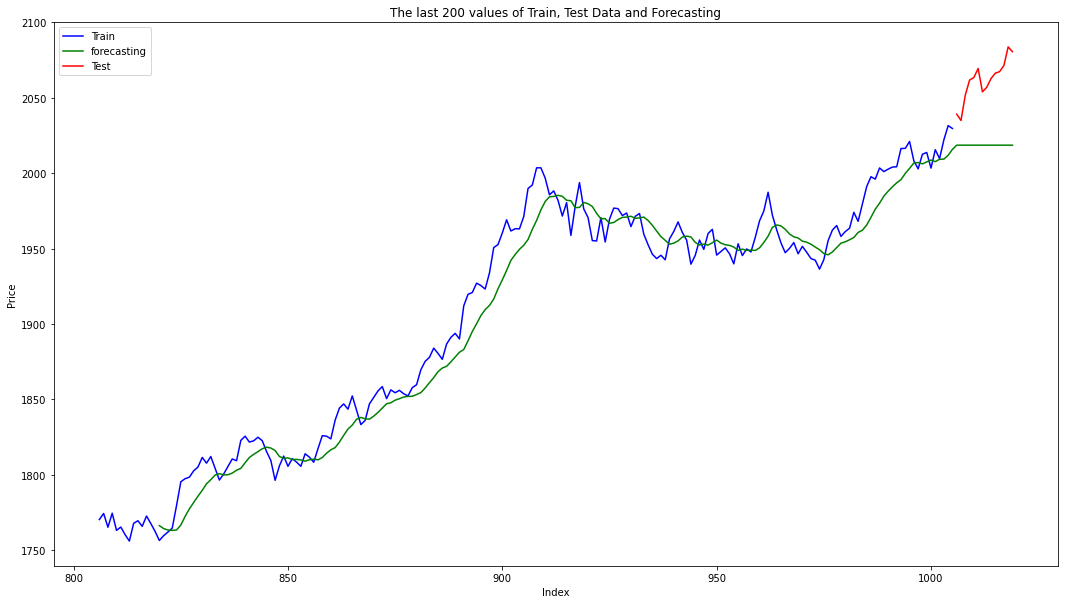

In [7]:
# Simple Exponential Smoothing with a smoothing level (alpha) = 0.2
Forecast, Error = SES_manual(train , test, 0.2, len(test))
# Keep a table with Forecasting and Error values
SES_table = pd.concat([Error, Forecast, test], axis=1)
SES_table = SES_table.rename(columns={0 : 'Actual'})

__Visualizing and Evaluating the SES Method with α=0.99 Using Multiple Performance Metrics__

Metrics to evaluate the Forecasting with a=0.9903366949267434
MAE - manual: 32.01110939261524
MAPE - manual: 0.01548557241877052
MSE - manual: 1200.2903082194493
RMSE - manual: 5.6578361051390695



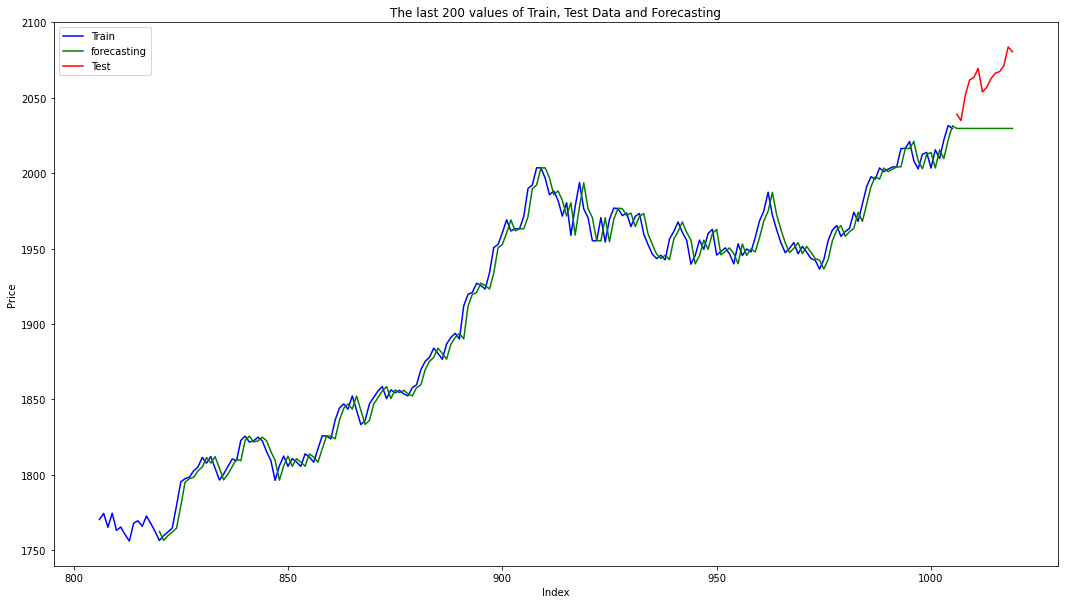

In [8]:
# Simple Exponential Smoothing with optimized smoothing level
Forecast, Error = SES_manual(train , test, optimized_smoothing_level, len(test))
# Keep a table with Forecasting and Error values
SES2_table = pd.concat([Error, Forecast, test], axis=1)
SES2_table = SES2_table.rename(columns={0 : 'Actual'})

__Presenting Tables Generated from the 2 Mathematical Models Outputs__

In [9]:
SES_table

,error,forecasting,Actual
0,0.0000,0.000000,NaN
1,1019.3000,0.000000,NaN
2,813.1400,203.860000,NaN
3,652.7120,366.488000,NaN
4,521.6696,497.030400,NaN
...,...,...,...
1015,0.0000,2018.616914,2066.4
1016,0.0000,2018.616914,2067.4
1017,0.0000,2018.616914,2071.4
1018,0.0000,2018.616914,2083.8


In [10]:
SES_table.tail(14)

,error,forecasting,Actual
1006,0.0,2018.616914,2039.2
1007,0.0,2018.616914,2035.0
1008,0.0,2018.616914,2051.8
1009,0.0,2018.616914,2061.8
1010,0.0,2018.616914,2063.5
1011,0.0,2018.616914,2069.5
1012,0.0,2018.616914,2054.0
1013,0.0,2018.616914,2057.0
1014,0.0,2018.616914,2062.8
1015,0.0,2018.616914,2066.4


In [11]:
SES2_table

,error,forecasting,Actual
0,0.000000,0.000000,NaN
1,1019.300000,0.000000,NaN
2,7.549807,1009.450193,NaN
3,2.272956,1016.927044,NaN
4,-0.478036,1019.178036,NaN
...,...,...,...
1015,0.000000,2029.717462,2066.4
1016,0.000000,2029.717462,2067.4
1017,0.000000,2029.717462,2071.4
1018,0.000000,2029.717462,2083.8


In [12]:
SES2_table.tail(14)

,error,forecasting,Actual
1006,0.0,2029.717462,2039.2
1007,0.0,2029.717462,2035.0
1008,0.0,2029.717462,2051.8
1009,0.0,2029.717462,2061.8
1010,0.0,2029.717462,2063.5
1011,0.0,2029.717462,2069.5
1012,0.0,2029.717462,2054.0
1013,0.0,2029.717462,2057.0
1014,0.0,2029.717462,2062.8
1015,0.0,2029.717462,2066.4


__Conclusion:__<br><br>
**The Simple Exponential Smoothing (SES) method didn't work well for our predictions. It assumes that the data stays the same over time (Stationary Data), but our data has trends and patterns that change. Because of this mismatch, SES didn't give us good forecasts. To make better predictions for this kind of data, we should consider using different methods that can handle trends and patterns (like Holt's Method).**